In [7]:
path = "/content/drive/MyDrive/Copy of KPI_Dataset.csv"  # your local path to the dataset

In [2]:
import matplotlib.pyplot as plt
from matplotlib import*
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
print(tf.__version__)  # should be 2.X

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
# To enlarge the plots
plt.rcParams['figure.figsize'] = [16, 8]

2.7.0


In [8]:
dataset = pd.read_csv(path, index_col=0)
dataset.head()

,Location,Volume_DL,PRB_usage_DL,Avg_act_UE_DL,CQI,RSSI_for_PUSCH,SINR_for_PUSCH,Avg MCS DL,Throughput_DL
0,CITY_A,301886.27,9.59,297.19,10.46,-99.02,16.57,13.97,22513.46
1,CITY_A,268234.87,8.41,250.95,10.52,-98.89,16.85,14.17,23775.42
2,CITY_A,237689.03,7.51,213.17,10.60,-98.82,17.02,14.30,25055.99
3,CITY_A,213198.99,6.76,182.56,10.68,-98.74,17.20,14.22,25674.69
4,CITY_A,189541.94,6.09,165.36,10.75,-98.69,17.34,14.20,25273.05


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
dataset = pd.get_dummies(dataset, columns=['Location'], prefix='', prefix_sep='')
dataset.head()

,Volume_DL,PRB_usage_DL,Avg_act_UE_DL,CQI,RSSI_for_PUSCH,SINR_for_PUSCH,Avg MCS DL,Throughput_DL,CITY_A,CITY_B,CITY_C
0,301886.27,9.59,297.19,10.46,-99.02,16.57,13.97,22513.46,1,0,0
1,268234.87,8.41,250.95,10.52,-98.89,16.85,14.17,23775.42,1,0,0
2,237689.03,7.51,213.17,10.60,-98.82,17.02,14.30,25055.99,1,0,0
3,213198.99,6.76,182.56,10.68,-98.74,17.20,14.22,25674.69,1,0,0
4,189541.94,6.09,165.36,10.75,-98.69,17.34,14.20,25273.05,1,0,0


In [10]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
print(f'There are {len(train_dataset)} training samples and {len(test_dataset)} test samples.')

There are 3146 training samples and 787 test samples.


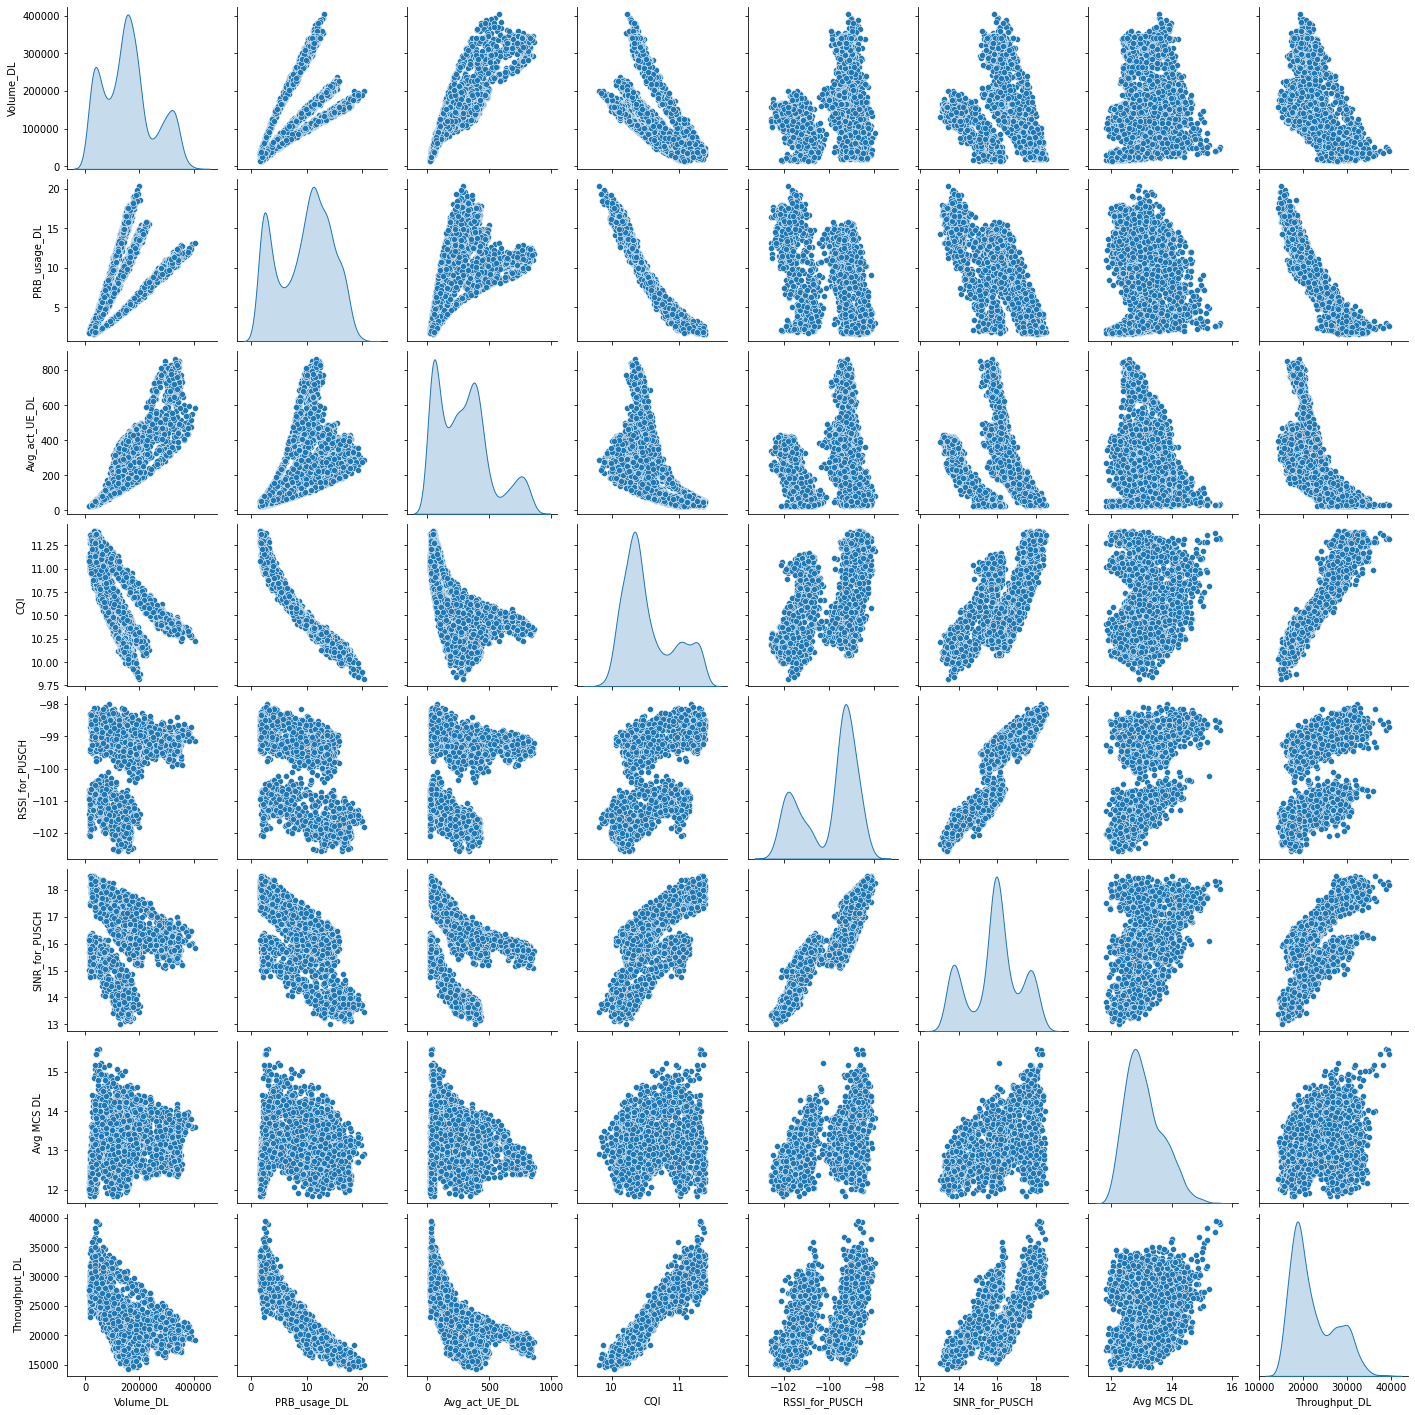

In [11]:
sns.pairplot(train_dataset[train_dataset.columns[:-3]], diag_kind='kde')

In [12]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Volume_DL,3146.0,158920.847317,92760.678364,12538.77,85626.3525,153313.760,201313.1375,404233.18
PRB_usage_DL,3146.0,9.573109,4.765634,1.57,5.1425,10.515,13.3400,20.31
Avg_act_UE_DL,3146.0,294.999746,215.271051,23.11,93.8000,276.915,410.5475,862.19
CQI,3146.0,10.542991,0.376786,9.82,10.2700,10.410,10.8100,11.40
RSSI_for_PUSCH,3146.0,-99.958922,1.198317,-102.57,-101.2000,-99.440,-99.0700,-97.98
SINR_for_PUSCH,3146.0,15.853601,1.332179,13.03,15.1900,15.940,16.6200,18.50
Avg MCS DL,3146.0,13.093115,0.627224,11.84,12.6225,12.980,13.5000,15.59
Throughput_DL,3146.0,22134.715528,4973.778090,14336.52,18331.3625,20497.855,26004.8150,39407.23
CITY_A,3146.0,0.332168,0.471066,0.00,0.0000,0.000,1.0000,1.00
CITY_B,3146.0,0.334075,0.471741,0.00,0.0000,0.000,1.0000,1.00


In [13]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

In [14]:
my_train_labels_PRB = train_features.pop('PRB_usage_DL')
my_test_labels_PRB = test_features.pop('PRB_usage_DL')

In [15]:

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))


first_model_PRB = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=256,activation="sigmoid"),
    layers.Dropout(rate=0.2),
    layers.Dense(units=128,activation="sigmoid"),
    layers.Dropout(rate=0.2),
    layers.Dense(units=64,activation="sigmoid"),
    layers.Dropout(rate=0.2), 
    layers.Dense(units=1)                                     
])

first_model_PRB.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 10)               21        
 n)                                                              
                                                                 
 dense (Dense)               (None, 256)               2816      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                        

In [16]:
first_model_PRB.layers[0].get_weights()

[array([158920.86 ,    295.   ,     10.543,    -99.959,     15.854,
            13.093,  22134.71 ,      0.332,      0.334,      0.334],
       dtype=float32),
 array([8.602e+09, 4.633e+04, 1.419e-01, 1.436e+00, 1.774e+00, 3.933e-01,
        2.473e+07, 2.218e-01, 2.225e-01, 2.224e-01], dtype=float32),
 3146]

In [17]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32)
    return lr

In [18]:
lr_schedule = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=20.0, 
    decay_steps=10000,
    end_learning_rate=0.01
)
optimizer = tf.optimizers.Adam(learning_rate=lr_schedule)
lr_metric = get_lr_metric(optimizer)

first_model_PRB.compile(
    optimizer=optimizer,
    metrics=lr_metric,
    loss='mean_absolute_error')

In [19]:
n_epochs=150
validation_split_size=0.2

history_PRB = first_model_PRB.fit(
    train_features,
    my_train_labels_PRB,
    epochs=n_epochs,
    verbose=1,
    validation_split=validation_split_size)

Epoch 1/150
79/79 [==============================] - 1s 7ms/step - loss: 103.7171 - lr: 19.9200 - val_loss: 23.7785 - val_lr: 19.8421
Epoch 2/150
79/79 [==============================] - 0s 4ms/step - loss: 25.0105 - lr: 19.7621 - val_loss: 12.1535 - val_lr: 19.6842
Epoch 3/150
79/79 [==============================] - 0s 4ms/step - loss: 33.4954 - lr: 19.6042 - val_loss: 19.3114 - val_lr: 19.5262
Epoch 4/150
79/79 [==============================] - 0s 4ms/step - loss: 28.3853 - lr: 19.4463 - val_loss: 24.6752 - val_lr: 19.3683
Epoch 5/150
79/79 [==============================] - 0s 4ms/step - loss: 33.4407 - lr: 19.2884 - val_loss: 25.3958 - val_lr: 19.2104
Epoch 6/150
79/79 [==============================] - 0s 4ms/step - loss: 21.3145 - lr: 19.1304 - val_loss: 26.1820 - val_lr: 19.0525
Epoch 7/150
79/79 [==============================] - 0s 4ms/step - loss: 28.1607 - lr: 18.9725 - val_loss: 10.8910 - val_lr: 18.8946
Epoch 8/150
79/79 [==============================] - 0s 4ms/step - l

In [ ]:
lr_schedule =tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3.0, 
    decay_steps=10000,
    decay_rate=0.2,
    staircase=True
)
optimizer = tf.optimizers.Adam(learning_rate=lr_schedule_Exp)
lr_metric = get_lr_metric(optimizer)

first_model_PRB.compile(
    optimizer=optimizer,
    metrics=lr_metric,
    loss='mean_absolute_error')

In [ ]:
plot_loss(history_PRB,zoom=False)

In [ ]:
metric= first_model_PRB.evaluate(test_features,my_test_lables_PRB,verbose=0)

# if your are not using a lr scheduler this should work
if type(metric) is float:
  test_results['first_model_PRB'] = metric
# otherwise this should work
else:
  test_results['first_model_PRB'] = metric[0]


print(f'The MAE on the DNN assessed on the test set is {test_results['first_model_PRB']:.2f}, is that a good value? Consider that the mean PRB is {dataset['PRB_usage_DL'].mean():.2f}.')

In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

my_train_labels_Volume = train_features.pop('Volume_DL')
my_test_labels_Volume = test_features.pop('Volume_DL')

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))


second_model_Volume =tf.keras.Sequential([
    normalizer,
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

second_model_Volume.summary()


In [ ]:
plot_loss(history_Volume)

In [ ]:
metric= second_model_Volume.evaluate(test_features,my_test_lables_Volume,verbose=0)

# if your are not using a lr scheduler this should work
if type(metric) is float:
  test_results['second_model_Volume'] = metric
# otherwise this should work
else:
  test_results['second_model_Volume'] = metric[0]


print(f'The MAE on the DNN assessed on the test set is {test_results['second_model_Volume']:.2f}, is that a good value? Consider that the mean PRB is {dataset['Volume_DL'].mean():.2f}.')

In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

my_train_labels_Volume = train_features.pop('Volume_DL')
my_test_labels_Volume = test_features.pop('Volume_DL')

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))


second_model_Volume2 =tf.keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

second_model_Volume2.summary()

In [ ]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32)
    return lr


lr_schedule =tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=20.0, 
    decay_steps=1000,
    decay_rate=0.4,
)  

optimizer = tf.optimizers.Adam(learning_rate=lr_schedule)   #_Exp
lr_metric = get_lr_metric(optimizer)

second_model_Volume2.compile(
    optimizer=optimizer,
    metrics=lr_metric,
    loss='mean_absolute_error')






In [ ]:
plot_loss(history_Volume2)

In [ ]:
metric= second_model_Volume2.evaluate(test_features,my_test_lables_Volume,verbose=0)

# if your are not using a lr scheduler this should work
if type(metric) is float:
  test_results['second_model_Volume2'] = metric
# otherwise this should work
else:
  test_results['second_model_Volume2'] = metric[0]


print(f'The MAE on the DNN assessed on the test set is {test_results['second_model_Volume2']:.2f}, is that a good value? Consider that the Volume mean  is {dataset['Volume_DL'].mean():.2f}.')

In [ ]:
test_predictions = second_model_Volume2.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(my_test_labels_Volume, test_predictions, edgecolor='black', linewidth=0.7)
plt.xlabel('True Values [Volume_DL]')
plt.ylabel('Predictions [Volume_DL]')
lims = [100000, 200000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)